In [45]:
import pandas as pd
import numpy as np
import os
import glob
from scipy.stats import pearsonr
from itertools import combinations

def load_data(file_paths):
    """Load barcode count files that are comma-separated, skipping 15 description lines."""
    all_data = []
    
    for file_path in file_paths:
        sample_name = os.path.basename(file_path).split('.')[0]

        try:
            df = pd.read_csv(
                file_path,
                sep=",",
                header=None,
                names=["Barcode_Pair", "Gene_Promoter", "Barcode", "Count"],
                dtype=str,
                skiprows=15,
                encoding='utf-8'
            )
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
            continue
        
        if df.shape[1] != 4:
            print(f"Warning: Unexpected number of columns in {file_path}. Columns: {df.columns}")
            continue
        
        df["Count"] = pd.to_numeric(df["Count"], errors="coerce")
        df["Sample"] = sample_name
        total_count = df["Count"].sum()
        if total_count > 0:
            df["Count"] = df["Count"] / total_count
        
        all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def find_global_sample_matches(df, correlation_threshold=0.95, min_nonzero_tus=2):
    """Identify globally matching sample pairs based on TU barcode patterns."""
    tu_counts = df[df["Count"] > 0].groupby("Sample")["Gene_Promoter"].nunique()
    valid_samples = tu_counts[tu_counts >= min_nonzero_tus].index
    df = df[df["Sample"].isin(valid_samples)].copy()

    if df.empty or len(valid_samples) < 2:
        print("Not enough valid samples for correlation.")
        return pd.DataFrame()

    df["Feature"] = df["Gene_Promoter"] + "__" + df["Barcode_Pair"]
    pivot = df.pivot_table(index="Sample", columns="Feature", values="Count", fill_value=0)

    matches = []
    for s1, s2 in combinations(pivot.index, 2):
        v1, v2 = pivot.loc[s1], pivot.loc[s2]
        if np.std(v1) == 0 or np.std(v2) == 0:
            continue
        corr, _ = pearsonr(v1, v2)
        if corr >= correlation_threshold:
            matches.append({"Sample1": s1, "Sample2": s2, "Correlation": corr})
    
    return pd.DataFrame(matches)

input_dir = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs'
file_paths = sorted(glob.glob(os.path.join(input_dir, 'Counts_*')))

data = load_data(file_paths)
global_matches = find_global_sample_matches(data, correlation_threshold=0.9)

output_csv = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jur_Val_sibling_identification.csv'

if not global_matches.empty:
    print(global_matches)
    global_matches.to_csv(output_csv, index=False)
else:
    print("No global matches found.")


             Sample1          Sample2  Correlation
0    Counts_BS27977A  Counts_BS28005A     0.998757
1    Counts_BS27977A  Counts_BS28664A     0.999158
2    Counts_BS27978A  Counts_BS27986A     0.998868
3    Counts_BS27978A  Counts_BS27990A     0.998961
4    Counts_BS27978A  Counts_BS27993A     0.999761
..               ...              ...          ...
429  Counts_BS28721A  Counts_BS28725A     0.995932
430  Counts_BS28721A  Counts_BS28726A     0.998963
431  Counts_BS28724A  Counts_BS28725A     0.996930
432  Counts_BS28724A  Counts_BS28726A     0.999362
433  Counts_BS28725A  Counts_BS28726A     0.997803

[434 rows x 3 columns]


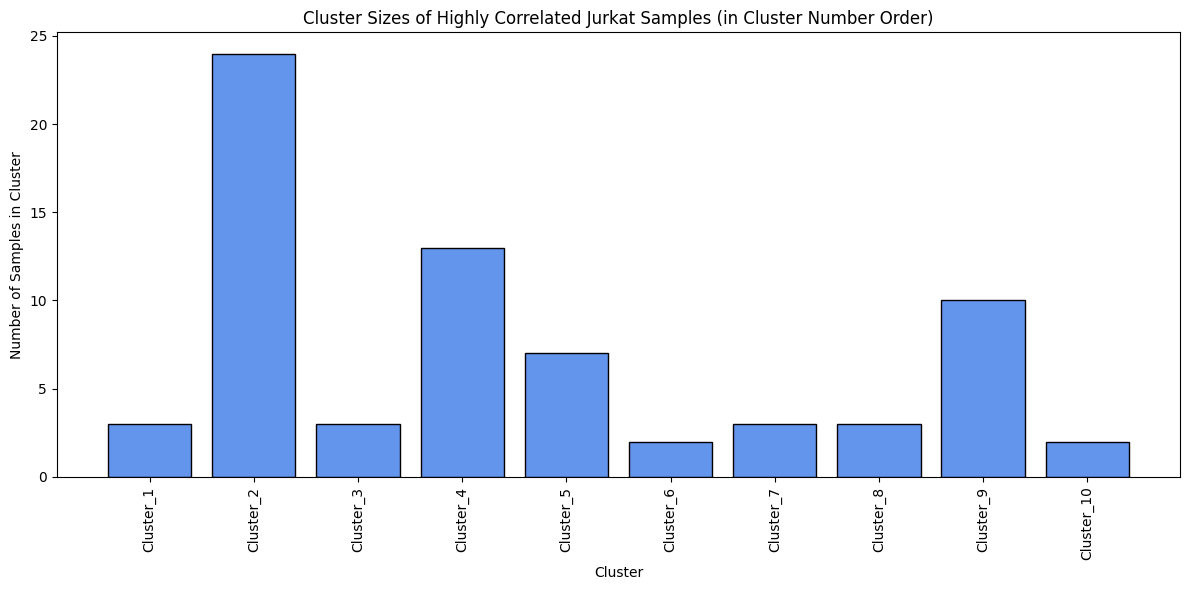

In [46]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Build graph from correlated sample pairs
G = nx.Graph()
G.add_edges_from(zip(global_matches["Sample1"], global_matches["Sample2"]))

# Get all unique samples from your normalized count data
all_samples = set(data["Sample"].unique())

# Extract connected components (clusters)
clusters = list(nx.connected_components(G))

# Assign cluster info to clustered samples
cluster_records = []
clustered_samples = set()
for cluster_id, cluster_samples in enumerate(clusters):
    cluster_name = f"Cluster_{cluster_id + 1}"
    cluster_size = len(cluster_samples)
    for sample in cluster_samples:
        clustered_samples.add(sample)
        cluster_records.append({
            "Sample": sample,
            "Cluster": cluster_name,
            "Cluster Size": cluster_size
        })

# Add singleton samples
singleton_samples = sorted(all_samples - clustered_samples)
for sample in singleton_samples:
    cluster_records.append({
        "Sample": sample,
        "Cluster": "",  # No cluster assigned
        "Cluster Size": ""
    })

# Create DataFrame and sort alphabetically by sample
cluster_df = pd.DataFrame(cluster_records).sort_values("Sample")

# Save to CSV
output_csv = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jur_Val_sibling_groups.csv"
cluster_df.to_csv(output_csv, index=False)

# Compute cluster sizes
cluster_sizes = (
    cluster_df[cluster_df["Cluster"] != ""]
    .groupby("Cluster")["Sample"]
    .count()
    .reset_index(name="Cluster Size")
)

# Sort clusters numerically by extracting the number from "Cluster_X"
cluster_sizes["Cluster Number"] = cluster_sizes["Cluster"].str.extract(r'Cluster_(\d+)').astype(int)
cluster_sizes = cluster_sizes.sort_values("Cluster Number")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(cluster_sizes["Cluster"], cluster_sizes["Cluster Size"], color="cornflowerblue", edgecolor="black")
plt.xticks(rotation=90)
plt.xlabel("Cluster")
plt.ylabel("Number of Samples in Cluster")
plt.title("Cluster Sizes of Highly Correlated Jurkat Samples (in Cluster Number Order)")
plt.tight_layout()
plt.show()


Cluster Val Score Summary:

Cluster_1: mean = 0.893, std = 0.367, n = 3
Cluster_2: mean = 1.099, std = 0.264, n = 24
Cluster_3: mean = 1.057, std = 0.060, n = 3
Cluster_4: mean = 1.155, std = 0.080, n = 13
Cluster_5: mean = 1.217, std = 0.124, n = 7
Cluster_6: mean = 0.815, std = 0.219, n = 2
Cluster_7: mean = 0.923, std = 0.143, n = 3
Cluster_8: mean = 1.167, std = 0.131, n = 3
Cluster_9: mean = 0.995, std = 0.190, n = 10
Cluster_10: mean = 1.030, std = 0.099, n = 2


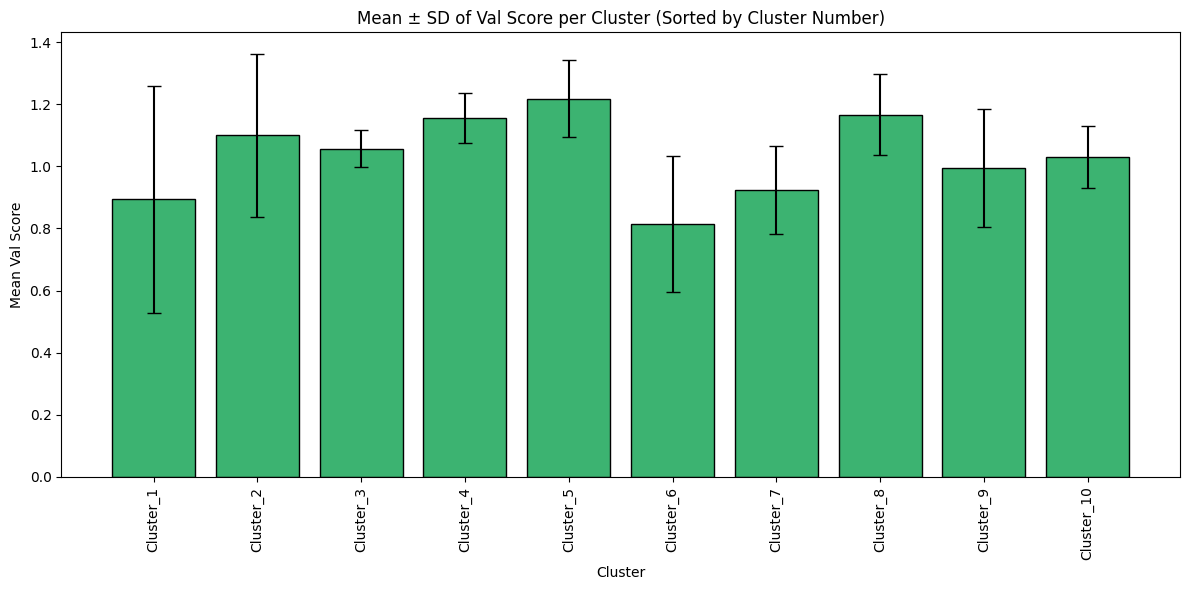

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the annotated CSV with Val scores
csv_path = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jur_Val_sibling_groups_InclValScore.csv"
df = pd.read_csv(csv_path)

# Filter to valid cluster assignments and Val scores
df_valid = df[df["Cluster"].notnull() & df["Val score"].notnull()].copy()

# Calculate mean, std, and count per cluster
cluster_stats = df_valid.groupby("Cluster")["Val score"].agg(["mean", "std", "count"]).reset_index()

# Extract numeric part of cluster label for sorting
cluster_stats["Cluster Number"] = cluster_stats["Cluster"].str.extract(r'Cluster_(\d+)').astype(int)
cluster_stats = cluster_stats.sort_values("Cluster Number")

# Print summary stats for each cluster
print("Cluster Val Score Summary:\n")
for _, row in cluster_stats.iterrows():
    print(f"{row['Cluster']}: mean = {row['mean']:.3f}, std = {row['std']:.3f}, n = {int(row['count'])}")

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(cluster_stats["Cluster"], cluster_stats["mean"], yerr=cluster_stats["std"],
               capsize=5, color="mediumseagreen", edgecolor="black")

plt.xticks(rotation=90)
plt.xlabel("Cluster")
plt.ylabel("Mean Val Score")
plt.title("Mean ± SD of Val Score per Cluster (Sorted by Cluster Number)")
plt.tight_layout()
plt.show()


File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27986A, Total Reads: 311230.0, Normalization Value: 0.0003213057867172188
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Counts_BS27986A_heatmap.svg


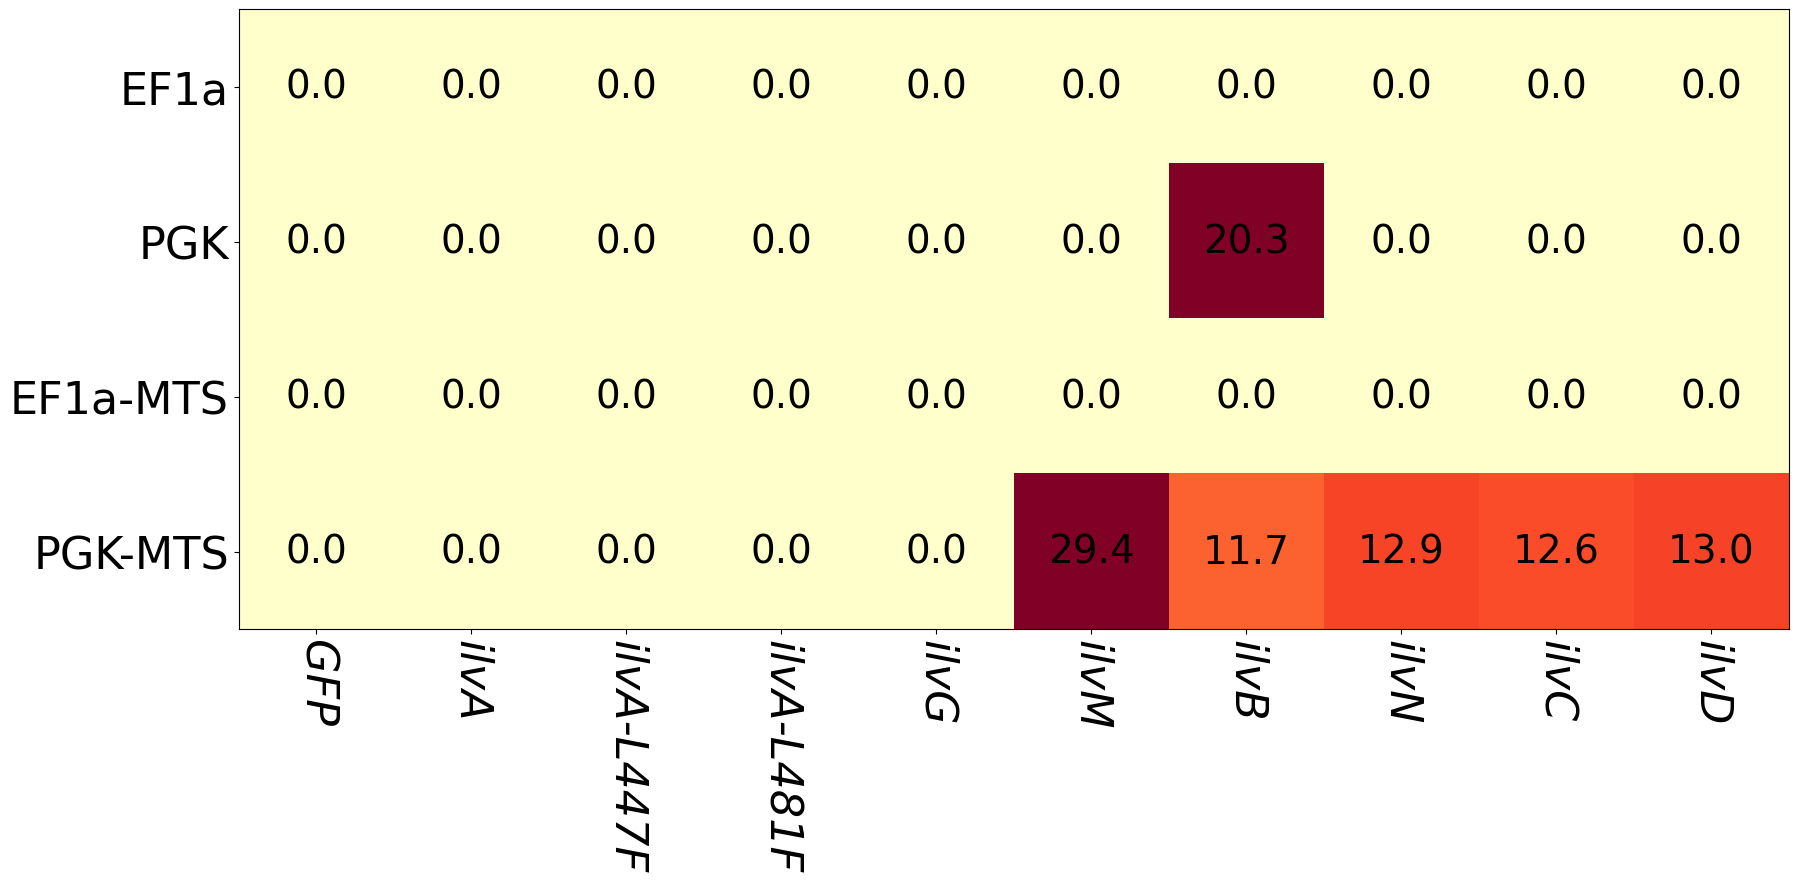

File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27989A, Total Reads: 405882.0, Normalization Value: 0.0002463770258350949
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Counts_BS27989A_heatmap.svg


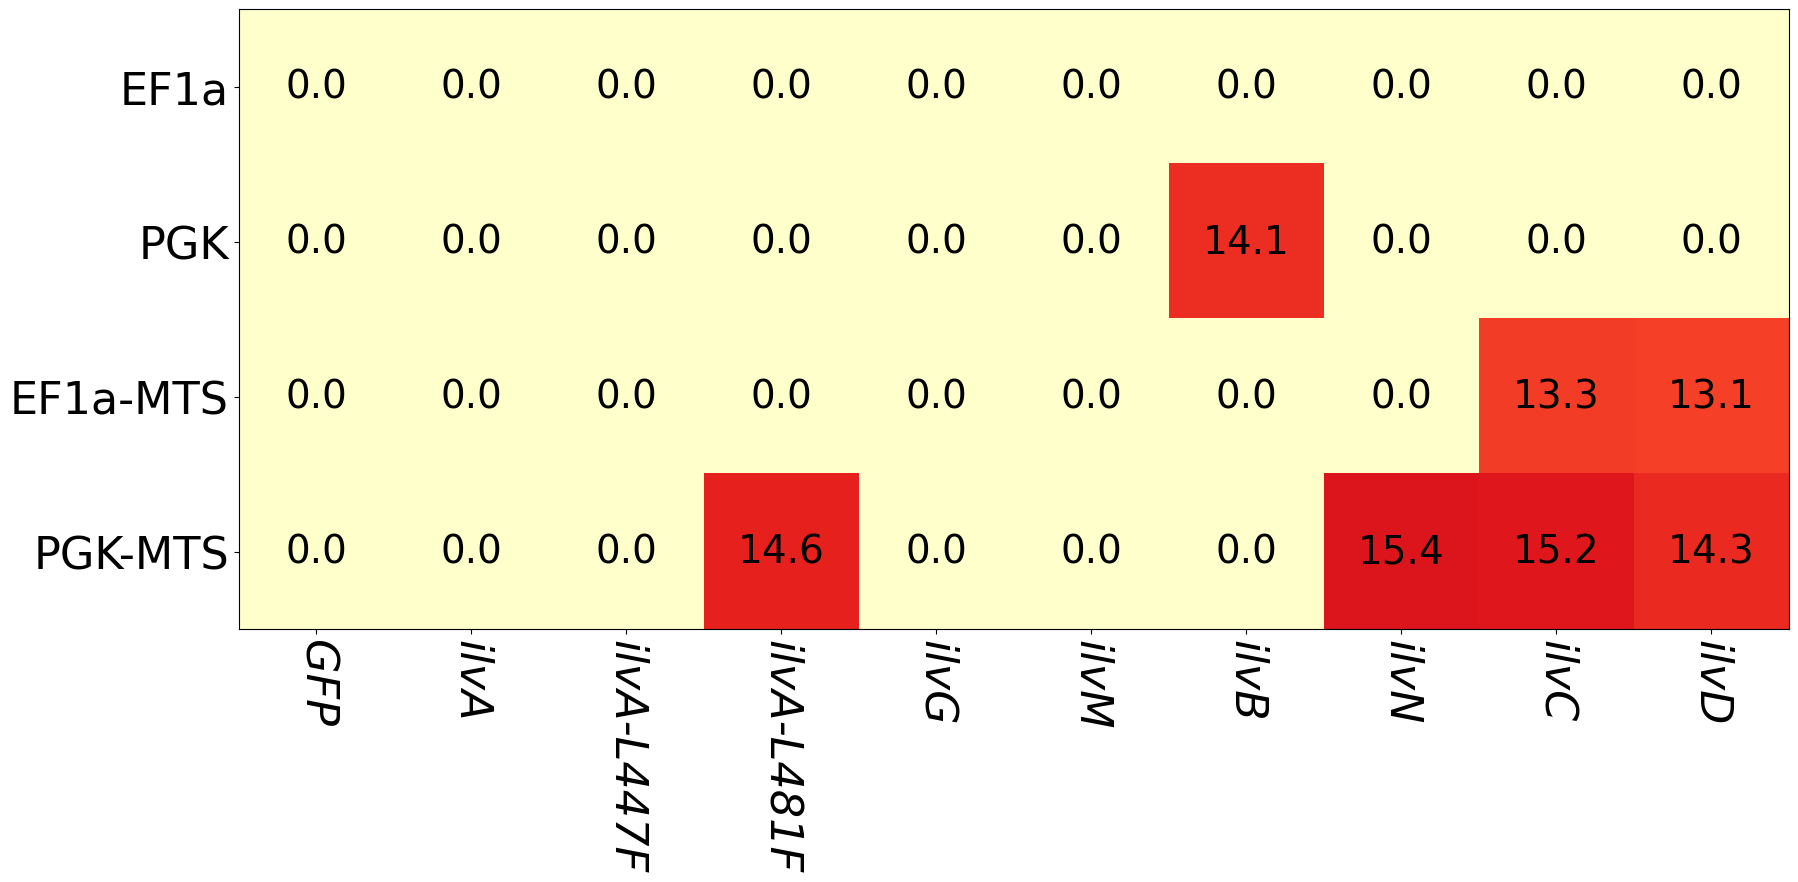

File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS28656A, Total Reads: 129142.0, Normalization Value: 0.0007743414226200617
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Counts_BS28656A_heatmap.svg


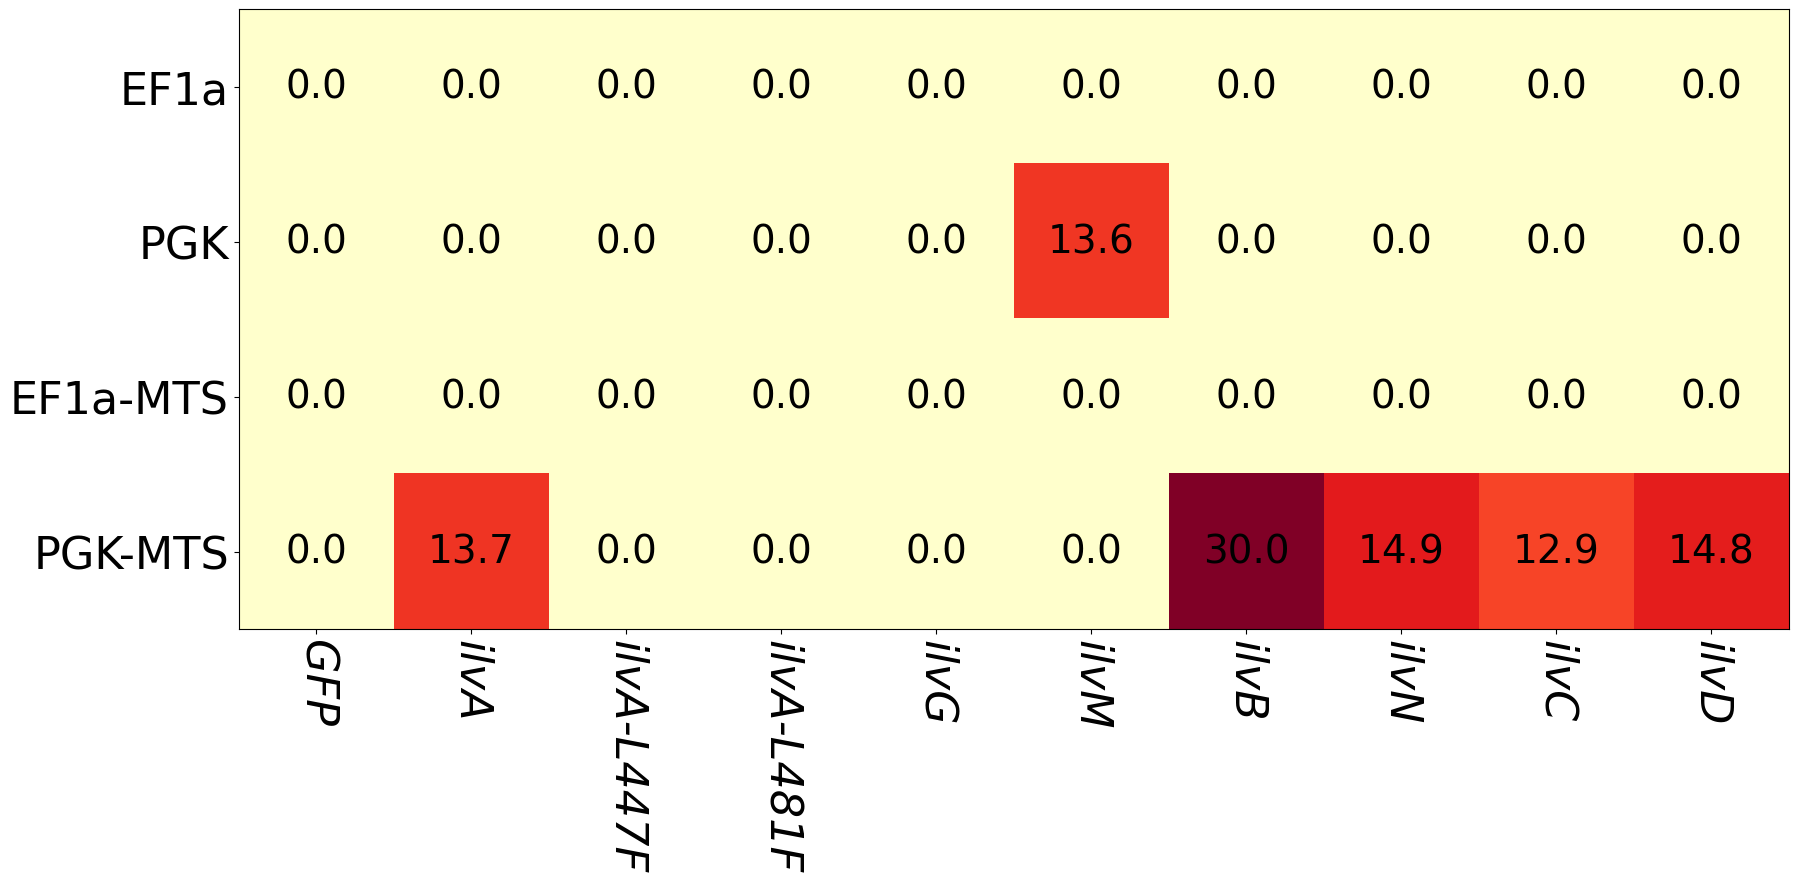

File: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27991A, Total Reads: 454406.0, Normalization Value: 0.0002200675167141279
Figure saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Counts_BS27991A_heatmap.svg


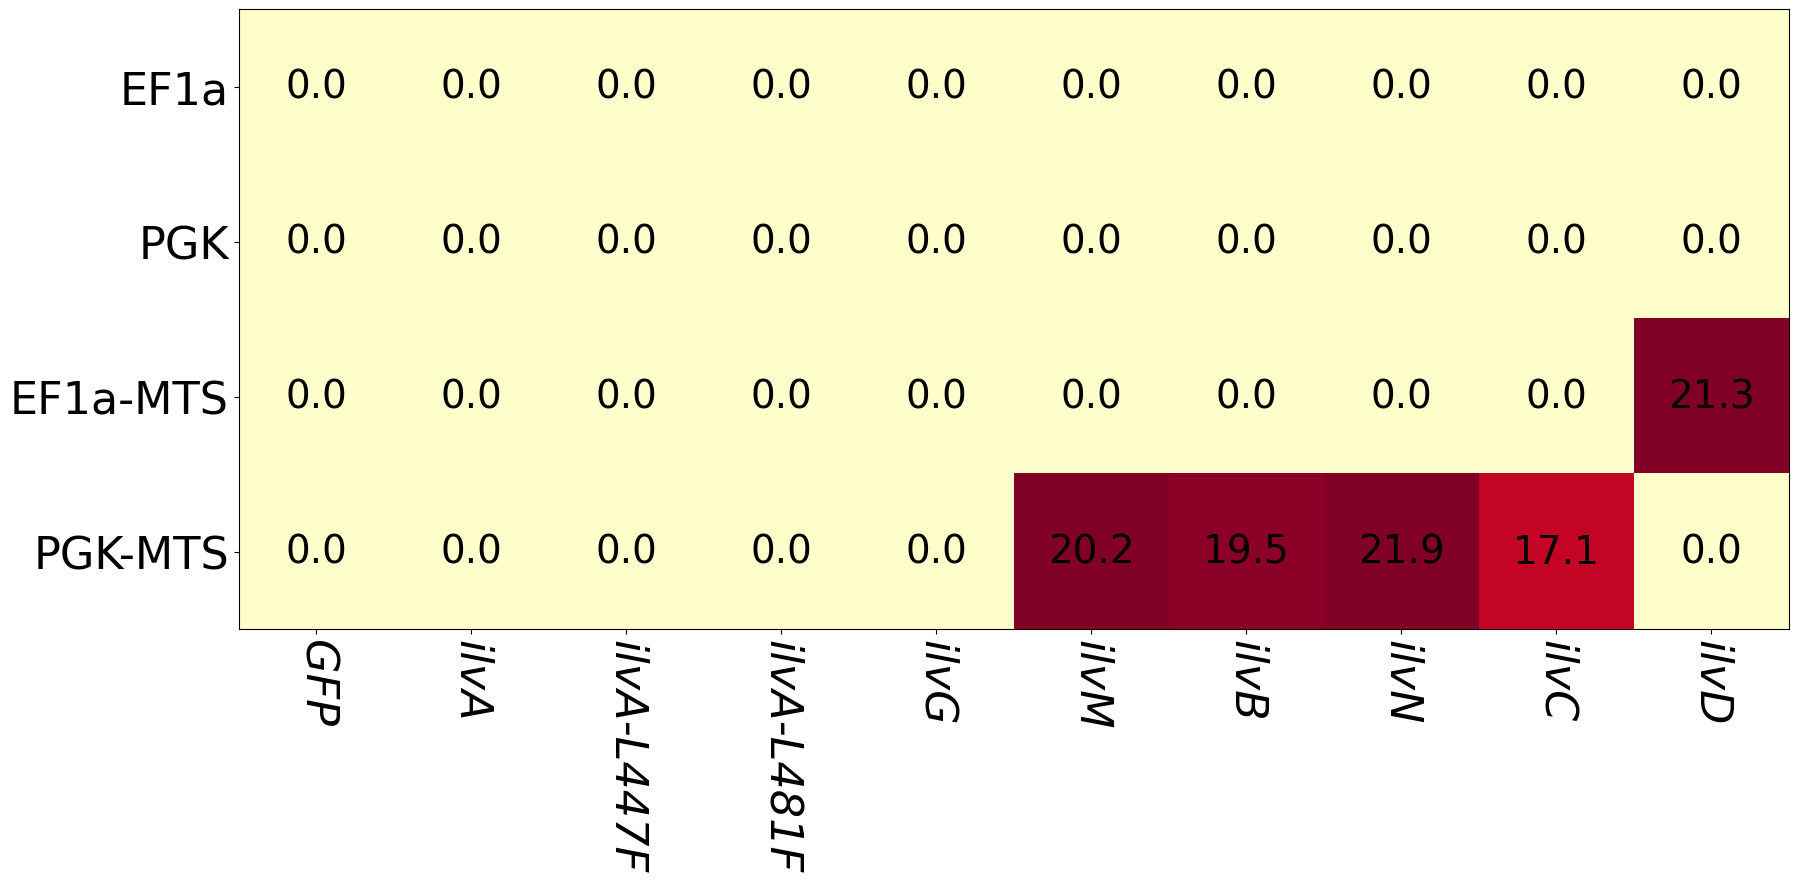

In [57]:
#top sibling groups, example heatmaps

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.colors import LinearSegmentedColormap


# List of input file paths
input_files = [
#sib group 2 (24 members)
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27986A',
#sib group 4 (12 members)
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27989A',
#sib group 9 (10 members)
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS28656A',
#sib group 5 (7 members)
'/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Counts/output_csvs/Counts_BS27991A',
]

# Define the desired output folder
output_folder = "/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs"

# Ensure the folder exists; create it if it doesn't
os.makedirs(output_folder, exist_ok=True)

# Define promoters and CDS
promoters = ['Ef1a', 'PGK']
mts_promoters = [f'{promoter}-MTS' for promoter in promoters]
cds = ['GFP', 'ilvA', 'ilvA mut 1', 'ilvA mut 2', 'ilvG', 'ilvM', 'ilvB', 'ilvN', 'ilvC', 'ilvD']

# Initialize variables to track the file with the highest figure
highest_figure = float('-inf')  # Start with the lowest possible value
highest_figure_file = None

# Dictionary to store figures and normalization values for each file
file_figures = {}
normalization_values = {}

# Loop through each input file
for file_path in input_files:
    # Read the CSV file into a DataFrame, skipping the first 17 rows
    df = pd.read_csv(file_path, skiprows=13, names=['BC Number', 'BC Name', 'Sequence', 'Counts'])

    # Calculate total reads for the file
    total_reads = df['Counts'].sum()

    # Calculate the normalization value (to make the total reads equal to 1,000,000)
    normalization_value = 100 / total_reads
    print(f"File: {file_path}, Total Reads: {total_reads}, Normalization Value: {normalization_value}")

    # Filter out unwanted rows
    filtered_df = df[
        (~df['BC Name'].str.contains("Unassigned")) &
        (df['BC Name'].str.contains(
            "Ef1a__|PGK__|CMV__|TightTRE__|NoProm__|Ef1a-MTS__|PGK-MTS__|CMV-MTS__|TightTRE-MTS__|NoProm-MTS__|__Ef1a|__PGK|__CMV|__TightTRE|__NoProm"
        ))
    ]

    # Initialize dictionary to store sums for the current file
    sum_TU = {}

    # Generate sums for each combination of promoter and CDS
    for promoter in promoters:
        for cd in cds:
            sum_TU[f'{promoter}_{cd}'] = (
                filtered_df.loc[filtered_df['BC Name'].str.contains(f"{cd}__{promoter}(?!-MTS)"), 'Counts'].sum() +
                filtered_df.loc[filtered_df['BC Name'].str.contains(f"{promoter}__{cd}(?!-MTS)"), 'Counts'].sum()) * normalization_value

    for promoter in mts_promoters:
        for cd in cds:
            sum_TU[f'{promoter}_{cd}'] = (
                filtered_df.loc[filtered_df['BC Name'].str.contains(f"{cd}__{promoter}"), 'Counts'].sum() +
                filtered_df.loc[filtered_df['BC Name'].str.contains(f"{promoter}__{cd}"), 'Counts'].sum()) * normalization_value

    # Create a DataFrame for the heatmap without rounding
    data = pd.DataFrame([
        [sum_TU[f'Ef1a_{cd}'] for cd in cds],
        [sum_TU[f'PGK_{cd}'] for cd in cds],
        [sum_TU[f'Ef1a-MTS_{cd}'] for cd in cds],
        [sum_TU[f'PGK-MTS_{cd}'] for cd in cds],
    ])
    
    # Create the heatmap without rounding
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    plt.imshow(data, cmap=plt.cm.YlOrRd, interpolation='nearest', vmin=0, vmax=20)
    
    # Add text annotations with two decimal points
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data.iloc[i, j]:.1f}", ha='center', va='center', color='black', fontsize=28)
    
    # Define custom x and y tick labels
    xtick_labels = ['GFP', 'ilvA', 'ilvA-L447F', 'ilvA-L481F', 'ilvG', 'ilvM', 'ilvB', 'ilvN', 'ilvC', 'ilvD']
    ytick_labels = ['EF1a', 'PGK', 'EF1a-MTS', 'PGK-MTS']
    
    # Set custom x and y tick labels
    plt.xticks(np.arange(len(xtick_labels)), xtick_labels, rotation=270, fontsize=32, fontstyle='italic')
    plt.yticks(np.arange(len(ytick_labels)), ytick_labels, fontsize=32)
    
    # Add title and labels
    # plt.xlabel('CDS', fontsize=32, labelpad=20)
    # plt.ylabel('Promoter', fontsize=32, labelpad=20)
    
    # Generate the output file name with the new folder path
    output_filename = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(file_path))[0]}_heatmap.svg")
    
    # Save the figure as an SVG file in the specified folder
    plt.savefig(output_filename, format='svg', dpi=300, bbox_inches='tight')
    
    # Display the saved file name (optional for debugging)
    print(f"Figure saved as: {output_filename}")
    
    # Show the plot (optional)
    plt.show()


                File Read_Quality    Cluster  Val score
0    Counts_BS27976A  Above_50000        NaN       0.06
1    Counts_BS27977A  Above_50000  Cluster_1       0.62
2    Counts_BS27978A  Above_50000  Cluster_2       1.10
3    Counts_BS27979A  Above_50000  Cluster_3       1.00
4    Counts_BS27980A  Above_50000        NaN       0.07
..               ...          ...        ...        ...
114  Counts_BS28722A  Above_50000        NaN       1.04
115  Counts_BS28723A  Above_50000  Cluster_2       1.06
116  Counts_BS28724A  Above_50000  Cluster_4       1.14
117  Counts_BS28725A  Above_50000  Cluster_4       1.06
118  Counts_BS28726A  Above_50000  Cluster_4       1.14

[119 rows x 4 columns]
Total samples: 119
Samples after filters: 73
Unique samples after sibling collapse: 18



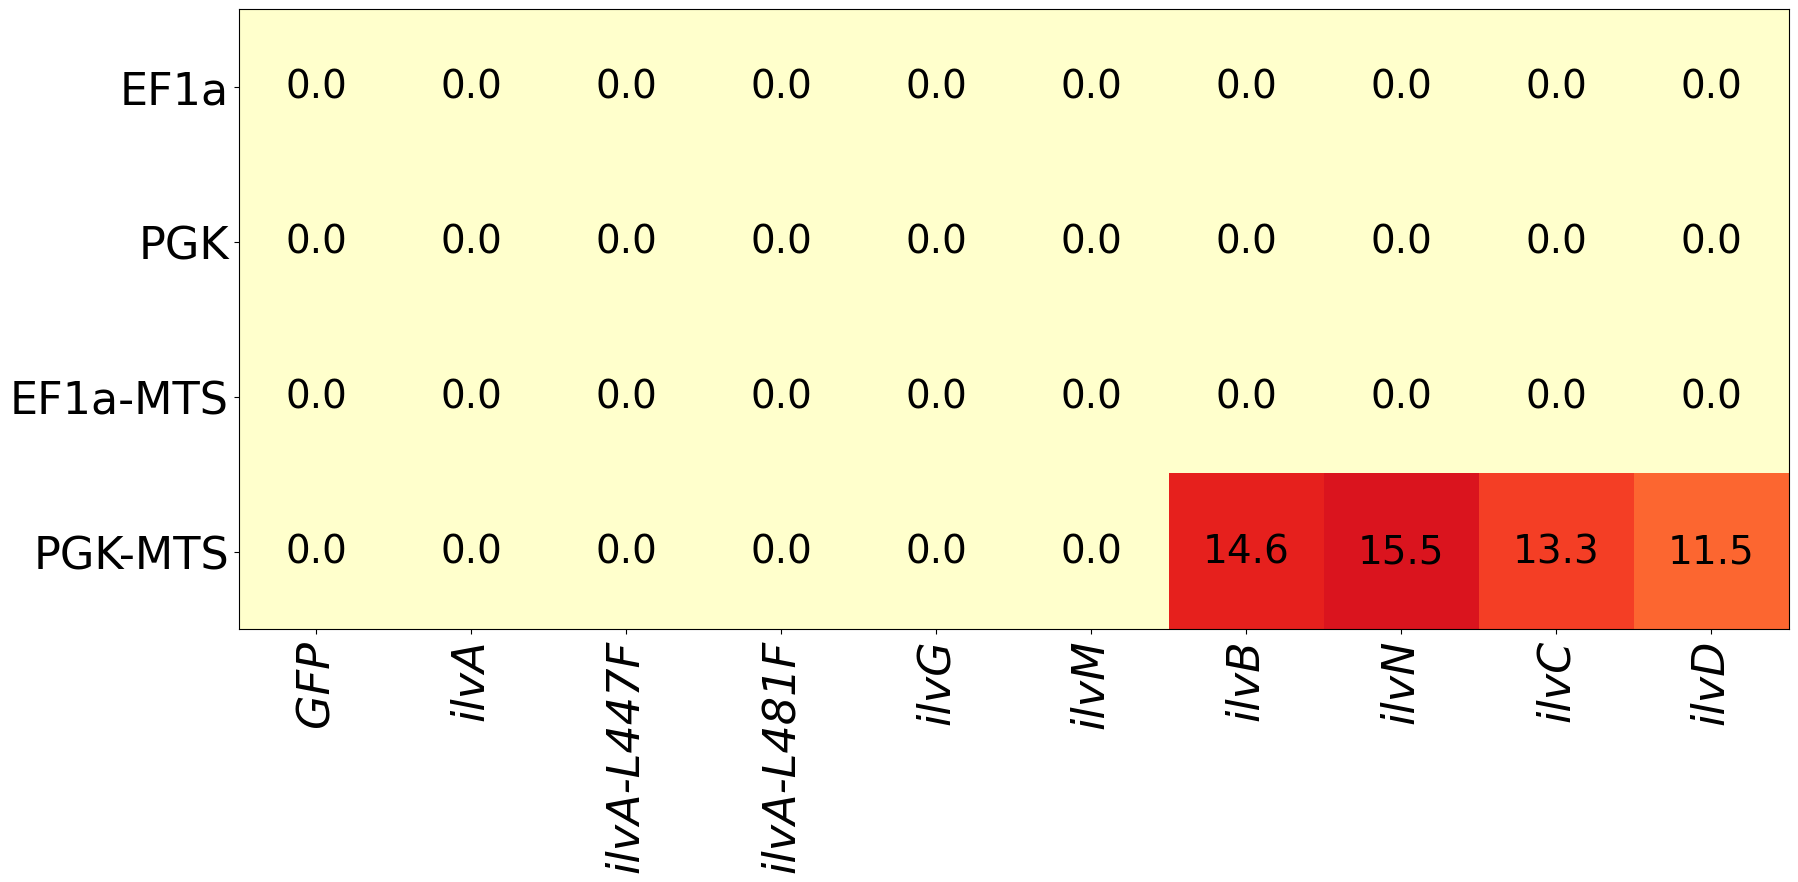

Filtered heatmap saved as: /Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Heatmaps/Jur_Val_no_sibs_median_heatmap.svg


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os

# ---------- SET PATHS ----------
file1_path = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jurkat_Val_RelativeReadCounts_InclValScore.csv'
file2_path = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_SummaryOutputs/Jur_Val_sibling_groups_InclValScore.csv'
output_heatmap_path = '/Users/trollj01/PycharmProjects/pythonProject1/20250527_SGE_FinalScripts/Jurkat_Valine/Jurkat_Valine_Heatmaps/Jur_Val_no_sibs_median_heatmap.svg'

# ---------- LOAD DATA ----------
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# ---------- MERGE FILES ----------
merged = pd.concat([
    df1[['File', 'Read_Quality']],
    df2[['Cluster', 'Val score']]
], axis=1)

print(merged)

# ---------- APPLY FILTERS ----------
val_score_col = 'Val score'
filtered = merged[
    (merged['Read_Quality'] == 'Above_50000') &
    (merged[val_score_col] > 0.75)
].copy()

# Assign singleton samples (Cluster = NaN) their File name as pseudo-cluster
filtered['Cluster'] = filtered.apply(
    lambda row: row['File'] if pd.isna(row['Cluster']) else row['Cluster'],
    axis=1
)

# Drop duplicate clusters (after filling in singletons)
filtered = filtered.sort_values('File')
filtered_unique = filtered.drop_duplicates(subset='Cluster', keep='first')

# Summary stats
print(f"Total samples: {len(df1)}")
print(f"Samples after filters: {len(filtered)}")
print(f"Unique samples after sibling collapse: {len(filtered_unique)}\n")

# ---------- PREPARE FOR HEATMAP ----------
data = df1  # Contains full feature matrix
feature_columns = data.columns[2:-1]  # Skip 'File', 'Read_Quality', and 'Val score'

# Merge to retain only samples in filtered_unique
feature_rows = data.merge(filtered_unique[['File']], on='File')

# Calculate feature medians
feature_medians = feature_rows[feature_columns].median(axis=0)

# Reshape for heatmap
feature_medians_df = feature_medians.reset_index()
feature_medians_df.columns = ['Feature', 'Median']
feature_medians_df[['Promoter', 'Gene']] = feature_medians_df['Feature'].str.split('_', expand=True)

# Pivot
heatmap_data = feature_medians_df.pivot(index='Promoter', columns='Gene', values='Median')

# Rename gene variants
heatmap_data = heatmap_data.rename(columns={
    'ilvA mut 1': 'ilvA-L447F',
    'ilvA mut 2': 'ilvA-L481F'
})

# Reorder promoters and genes
promoter_order = ['Ef1a', 'PGK', 'Ef1a-MTS', 'PGK-MTS']
gene_order_updated = ['GFP', 'ilvA', 'ilvA-L447F', 'ilvA-L481F', 'ilvG', 'ilvM', 'ilvB', 'ilvN', 'ilvC', 'ilvD']
heatmap_data = heatmap_data.loc[promoter_order, gene_order_updated]

# Plot the heatmap
plt.figure(figsize=(20, 10))
plt.imshow(heatmap_data, cmap=plt.cm.YlOrRd, interpolation='nearest', vmin=0, vmax=20)

# Add text annotations
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        plt.text(j, i, f"{heatmap_data.iloc[i, j]:.1f}", ha='center', va='center', color='black', fontsize=28)

# Set tick labels
plt.xticks(np.arange(len(gene_order_updated)), gene_order_updated, rotation=90, fontsize=32, fontstyle='italic')
plt.yticks(np.arange(len(promoter_order)), ['EF1a', 'PGK', 'EF1a-MTS', 'PGK-MTS'], fontsize=32)

# Save and display
os.makedirs(os.path.dirname(output_heatmap_path), exist_ok=True)
plt.savefig(output_heatmap_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()

print(f"Filtered heatmap saved as: {output_heatmap_path}")
